In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.transform import resize
import matplotlib.patches as patches
from keras.models import Sequential
from scipy.stats.stats import pearsonr
from scipy.ndimage.filters import gaussian_filter as gf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

from hyss_util import *

2023-07-20 14:08:57.140423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 14:08:57.262096: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-20 14:08:57.667581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-20 14:08:57.667629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
plt.style.use("bmh")

# -- set grayscale to be the default color map
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams['axes.titlepad'] = 0 

In [8]:
# -- TECHNOLOGY TYPING WITH COEF VALUE
# -- load raw spec data for both scan
hsi0_spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T
hsi1_spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T


# -- load spec location
spec_loc_hsi0 = np.load("../output/hsi0_overlap_location_bridge.npy")
spec_loc_hsi1 = np.load("../output/hsi1_overlap_location_bridge.npy")


# -- load waves range for both scans
waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

# -- load templates, waves, and names
spectra = np.load("../output/final_spectra_20.npy").T
names = np.load("../output/final_name_20.npy")
wavelengths = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

In [9]:
# -- interpolate the hsi0 spectra 
hsi0_inter = np.empty((len(hsi0_spec), len(waves1)))
for i in range(0, len(hsi0_spec)):
    interp = np.interp(waves1, waves0, (hsi0_spec)[i])
    hsi0_inter[i,:] = (interp)

In [10]:
# -- get coef value for each sources
def get_coef(spec_pixel, spec_loc):

  """
  Read "active" pixel in either 2013 scan or 2018 scan

  Parameters:
  ----------
  spec_pixel: two dimentional numpy array
             raw spectra of all "active" pixel

  spec_loc: two dimentional numpy array
            "active" pixels' location

  Returns:
  -------

  coor: two dimentional numpy array
       20 correlation values with all "active" pixel
  fit: a dataframe
      Columns: The index of the highest correlation value,
       The highest correlation value, Lighting technology name, 
       Location(x and y)

  """

  # -- load lab spectra, their lighting technology names and wavelength
  names = np.load("../output/final_name_20.npy")
  spectra = np.load("../output/final_spectra_20.npy")
  wavelengths = np.load("../output/graham_hall_upload/lspdd_lab_spectra_wavelengths.npy")

  # -- interpolate the NOAA and lspdd lab spectra wavelengths (x-coordinates) to the wavelengths of the HSI scan
  spectra2 = np.empty((len(spectra), len(waves1)))
  for i in range(0, len(spectra)):
    interp = np.interp(waves1, wavelengths, spectra[i])
    spectra2[i,:] = (interp)

  # -- standardize lab spectra data
  spectra2_st = np.empty(spectra2.shape)
  for i in range(0, len(spectra2)):
    st = (spectra2[i] - spectra2[i].mean()) / spectra2[i].std()
    spectra2_st[i, :] = st

  # -- standardize "active" sources' spectra data  
  spec_st = np.empty(spec_pixel.shape)
  for i in range(0, spec_pixel.shape[0]):
    st = (spec_pixel[i, :] - spec_pixel[i, :].mean()) / spec_pixel[i, :].std()
    spec_st[i, :] = st

  # -- coorelate spectrum of each pixel with NOAA lab spectra
  coor = np.empty((spec_pixel.shape[0], len(spectra2)))
  for i in range(0, spec_pixel.shape[0]):
    for j in range(0, len(spectra2)):
      coef, pvalue = pearsonr(spectra2[j, :], spec_st[i, :])
      coor[i, j] = coef

  # -- get maximum coorelation value and index for each pixel
  fit = np.empty((spec_pixel.shape[0], 2))
  for i in range(0, spec_pixel.shape[0]):
    maxIndex = np.argmax(coor[i, :])
    fit[i, 0] = maxIndex
    maxValue = np.amax(coor[i, :])
    fit[i, 1] = maxValue
  
  # -- get corresponding lighting technology name with maximum correlation value
  lnames = []
  for num in fit[:, 0]:
    lnames.append(names[num.astype("int")])

  # -- change it to dataframe and include source locations
  fit = pd.DataFrame(fit)
  fit["name"] = lnames
  fit["x"] = spec_loc[:, 1]
  fit["y"] = spec_loc[:, 0]
  
  return coor, fit

In [11]:
# -- get correlation value for "active" sources in both images
coor_hsi0, fit_hsi0 = get_coef(hsi0_inter, spec_loc_hsi0)
coor_hsi1, fit_hsi1 = get_coef(hsi1_spec, spec_loc_hsi1)

In [12]:
fit_hsi0[fit_hsi0[1]  < 0 ]

,0,1,name,x,y


In [13]:
fit_hsi1[fit_hsi1[1] < 0 ]

,0,1,name,x,y


In [14]:
# -- get plotted lighting technologies name 
def get_lighting_type(fit, thre):

  """
  Print lighting types according to their coor values

  Parameters:
  ----------
  fit: a dataframe
      Columns: The index of the highest correlation value,
       The highest correlation value, Lighting technology name, 
       Location(x and y)
  
  thre: the threshold of keeping this pixel as source

  Returns:
  -------
  Six lighting technologies and their location,
  High_Pressure_Sodium, LED, Incandescent, Metal_Halide, Fluorescent, OIL.
  
  """

  # -- thresholding correlation value
  sub_lighting = fit[fit[1] > thre]
  
  # -- get the high pressure soidum category
  High_Pressure_Sodium0 = sub_lighting[sub_lighting["name"].str.contains("HPS")]
  High_Pressure_Sodium1= sub_lighting[sub_lighting["name"].str.contains("High_Pressure_Sodium")]
  High_Pressure_Sodium = pd.concat([High_Pressure_Sodium0,High_Pressure_Sodium1])

  # -- get the LED category
  LED = sub_lighting[sub_lighting["name"].str.contains("LED")]

  # -- get the Incandescent category
  Incandescent0 = sub_lighting[sub_lighting["name"].str.contains("Incandescent")]
  Incandescent1 = sub_lighting[sub_lighting["name"].str.contains("INC")]
  Incandescent = pd.concat([Incandescent0,Incandescent1])

  # -- get the Metal_Halide category
  Metal_Halide0 = sub_lighting[sub_lighting["name"].str.contains("Metal_Halide")]
  Metal_Halide1 = sub_lighting[sub_lighting["name"].str.contains("MH")]
  Metal_Halide = pd.concat([Metal_Halide0,Metal_Halide1])

  # -- get the Fluorescent category
  Fluorescent0 = sub_lighting[sub_lighting["name"].str.contains("CFL")]
  Fluorescent1 = sub_lighting[sub_lighting["name"].str.contains("Fluorescent")]
  Fluorescent = pd.concat([Fluorescent0,Fluorescent1])

  # -- get the OIL category
  OIL = sub_lighting[sub_lighting["name"].str.contains("Oil")]

  return High_Pressure_Sodium, LED, Incandescent, Metal_Halide, Fluorescent, OIL

In [15]:
# -- get plotted lighting technology name and location
High_Pressure_Sodium_hsi1, Light_emitting_diode_hsi1, Incandescent_hsi1, Metal_Halide_hsi1, Fluorescent_hsi1, OIL_hsi1 = get_lighting_type(fit_hsi1, 0.25)
High_Pressure_Sodium_hsi0, Light_emitting_diode_hsi0, Incandescent_hsi0, Metal_Halide_hsi0, Fluorescent_hsi0, OIL_hsi0 = get_lighting_type(fit_hsi0, 0.25)

In [16]:
# -- load 2013 and 2015 images
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")
imgL_hsi1 = np.load("../output/img_L1_fnl.npy")

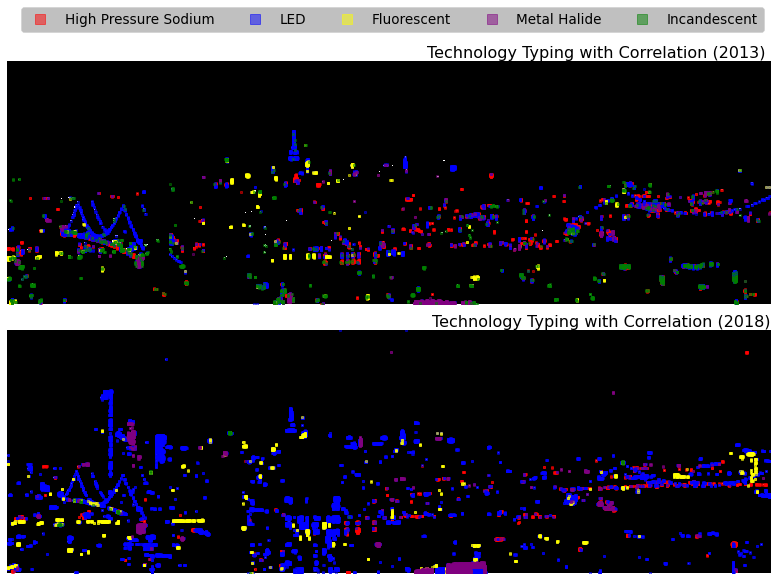

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")
ax[0].plot(High_Pressure_Sodium_hsi0["x"], High_Pressure_Sodium_hsi0["y"], c = "red", label = 'High Pressure Sodium', alpha = 0.5,marker="s", ms=2.5, linestyle='')

ax[0].plot(Light_emitting_diode_hsi0["x"], Light_emitting_diode_hsi0["y"], c = "blue",  marker="s", label = 'LED', alpha = 0.5 , ms=2.5, linestyle='' )
ax[0].plot(Fluorescent_hsi0["x"], Fluorescent_hsi0["y"], c = "yellow", label = 'Fluorescent', alpha = 0.5, marker="s",ms=2.5, linestyle='')
ax[0].plot(Metal_Halide_hsi0["x"], Metal_Halide_hsi0["y"], c = "purple", label = 'Metal Halide', alpha = 0.5,marker="s", ms=2.5, linestyle='')
ax[0].plot(Incandescent_hsi0["x"], Incandescent_hsi0["y"], c = "green", label = 'Incandescent', alpha = 0.5,marker="s", ms=2.5, linestyle='')

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 13.6, facecolor = "silver", framealpha = 1)
ax[0].set_title("Technology Typing with Correlation (2013) ", loc = "right", fontsize = 16)
ax[0].axis('off')



ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(High_Pressure_Sodium_hsi1["x"], High_Pressure_Sodium_hsi1["y"], c = "red", label = 'High_Pressure_Sodium', alpha = 0.5, marker="s",ms=2.5, linestyle='')

ax[1].plot(Light_emitting_diode_hsi1["x"], Light_emitting_diode_hsi1["y"], c = "blue", label = 'LED', alpha = 0.5, marker="s",ms=2.5, linestyle='')
ax[1].plot(Fluorescent_hsi1["x"], Fluorescent_hsi1["y"], c = "yellow", label = 'Fluorescent', alpha = 0.5,marker="s", ms=2.5, linestyle='')
ax[1].plot(Metal_Halide_hsi1["x"], Metal_Halide_hsi1["y"], c = "purple", label = 'Metal_Halide', alpha = 0.5, marker="s",ms=2.5, linestyle='')
ax[1].plot(Incandescent_hsi1["x"], Incandescent_hsi1["y"], c = "green", label = 'Incandescent', alpha = 0.5, marker="s",ms=2.5, linestyle='')




# ax.scatter(OIL["x"], OIL["y"], c = "pink", label = 'Halogen', alpha = 0.5, s=5)

#ax[1].legend(loc = "upper left")
ax[1].set_title("Technology Typing with Correlation (2018)", loc = "right", fontsize = 16)
ax[1].axis('off')
fig.tight_layout()

In [18]:
# -- 1D-CNN MODEL
# -- load source spectra and type for both hsi0 and hsi1
cnn_hsi0 = np.load("../output/graham_hall_upload/hsi0spec_labeled.npy", allow_pickle=True)
cnn_hsi1 = np.load("../output/graham_hall_upload/hsi1spec_labeled.npy", allow_pickle=True)

# -- targ
targ_hsi0 = np.load("../output/graham_hall_upload/hsi0_labeled_targ.npy", allow_pickle=True)
targ_hsi1 = np.load("../output/graham_hall_upload/hsi1_labeled_targ.npy", allow_pickle=True)





In [19]:
# -- interpolate the hsi0 spectra 
cnn_hsi0_inter = np.empty((len(cnn_hsi0), len(waves1)))
for i in range(0, len(cnn_hsi0)):
    interp = np.interp(waves1, waves0, cnn_hsi0[:, :872][i])
    cnn_hsi0_inter[i,:] = (interp)


# -- interpolate the wavelengths of the HSI scan
cnn_hsi1_spec = cnn_hsi1[:, :848]

In [20]:
# -- normlize raw data 
def norm(feat):

  """
  Read source spectra

  Parameters:
  ----------
  feat: a two dimentional array of source spectra

  Returns:
  -------
  a two dimentional array
  normlized source spectra
  
  """
  feat_norm = np.empty(feat.shape)
  for i in range(0, len(feat)):
    norm = (feat[i] - feat[i].min()) / (feat[i].max() - feat[i].min())
    feat_norm[i, :] = norm
  return feat_norm

cnn_hsi1_spec_norm = norm(cnn_hsi1_spec)
cnn_hsi0_spec_norm = norm(cnn_hsi0_inter)

# # -- change to low resolution
# cnn_hsi0_spec_norm = cnn_hsi0_spec_norm[:, ::2]
# cnn_hsi1_spec_norm = cnn_hsi1_spec_norm[:, ::2]


# -- combine both scans' feature 
feat = np.vstack([cnn_hsi0_spec_norm, cnn_hsi1_spec_norm])

In [21]:
feat.shape

(1329, 848)

In [22]:
# -- get target  
target_hsi1 = targ_hsi1.astype(str)
target_hsi0 = targ_hsi0.astype(str)

# -- hsi1
target_dict = {'High_Pressure_Sodium': 0,'LED': 1, 'Fluorescent': 2,'Metal_Halide': 3, 'Incandescent': 4, "Unknown" :5 }
target_hsi1 = np.array([target_dict[item] for item in target_hsi1]).astype("int")
target_hsi1

# -- hsi0
target_hsi0 = np.array([target_dict[item] for item in target_hsi0]).astype("int")
target_hsi0

# -- combine both scans' target
target = np.concatenate([target_hsi0, target_hsi1])
target.shape

(1329,)

In [16]:
# -- create a training and testing set
feature = feat
targ = target

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feature, targ, test_size=0.2, random_state=302)

# -- check the shapes of the data
print("training set shape : ", feat_tr.shape)
print("testing set shape  : ", feat_te.shape)

training set shape :  (1063, 848)
testing set shape  :  (266, 848)


In [17]:
# -- Testing data in this model are the spectra come from both scans
# -- the testing data in this model are the spectra come from both scans

layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu") 
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr2 = feat_tr.reshape(1063, 848, 1)
feat_te2 = feat_te.reshape(266, 848, 1)

cnn_hsi0_spec_norm2 = cnn_hsi0_spec_norm.reshape(713, 848, 1)
cnn_hsi1_spec_norm2 = cnn_hsi1_spec_norm.reshape(616, 848, 1)

# -- fit the model
history = model.fit(feat_tr2, targ_tr, epochs=20, batch_size=20)

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr2, targ_tr)
# -- print the accuracy
loss_te, acc_te = model.evaluate(feat_te2, targ_te)


loss_te_hsi0, acc_te_hsi0 = model.evaluate(cnn_hsi0_spec_norm2, target_hsi0)
loss_te_hsi1, acc_te_hsi1 = model.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Training accuracy : {0:.4f}".format(acc_tr))
#print("Training accuracy : {0:.4f}".format(acc_te))

print("Testing accuracy hsi1 : {0:.4f}".format(acc_te_hsi1))
print("Testing accuracy hsi0 : {0:.4f}".format(acc_te_hsi0))

Epoch 1/20


2023-07-19 13:55:05.865324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 13:55:05.917690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-07-19 13:55:05.917714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-07-19 13:55:05.918266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

54/54 [==============================] - 3s 53ms/step - loss: 0.7825 - accuracy: 0.6933
Epoch 2/20
54/54 [==============================] - 3s 51ms/step - loss: 0.3667 - accuracy: 0.8551
Epoch 3/20
54/54 [==============================] - 3s 53ms/step - loss: 0.2864 - accuracy: 0.8946
Epoch 4/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2311 - accuracy: 0.9116
Epoch 5/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2458 - accuracy: 0.9050
Epoch 6/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1738 - accuracy: 0.9360
Epoch 7/20
54/54 [==============================] - 3s 52ms/step - loss: 0.2045 - accuracy: 0.9266
Epoch 8/20
54/54 [==============================] - 3s 51ms/step - loss: 0.1393 - accuracy: 0.9539
Epoch 9/20
54/54 [==============================] - 3s 53ms/step - loss: 0.1336 - accuracy: 0.9454
Epoch 10/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1254 - accuracy: 0.9530
Epoch 11/20
54/54 [=

In [18]:
from sklearn.metrics import classification_report

target_names = ['High_Pressure_Sodium','LED', 'Fluorescent','Metal_Halide', 'Incandescent', 'unknown']

In [19]:
pred_hsi0 = model.predict(cnn_hsi0_spec_norm2)
pred_hsi1 = model.predict(cnn_hsi1_spec_norm2)

20/20 [==============================] - 0s 11ms/step


In [20]:
pred_hsi0_matrix = [pred_hsi0[i].argmax() for i in range(len(pred_hsi0))]
print(classification_report(target_hsi0, pred_hsi0_matrix, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       1.00      0.99      1.00       158
                 LED       0.99      0.97      0.98        75
         Fluorescent       1.00      0.99      0.99        81
        Metal_Halide       1.00      0.98      0.99       117
        Incandescent       0.99      1.00      0.99        83
             unknown       0.97      0.99      0.98       199

            accuracy                           0.99       713
           macro avg       0.99      0.99      0.99       713
        weighted avg       0.99      0.99      0.99       713



In [21]:
pred_hsi1_matrix = [pred_hsi1[i].argmax() for i in range(len(pred_hsi1))]
print(classification_report(target_hsi1, pred_hsi1_matrix, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.98      0.98      0.98       119
                 LED       0.98      0.99      0.98       123
         Fluorescent       0.99      1.00      1.00       103
        Metal_Halide       1.00      0.99      1.00       106
        Incandescent       0.98      1.00      0.99        62
             unknown       0.97      0.94      0.96       103

            accuracy                           0.98       616
           macro avg       0.98      0.98      0.98       616
        weighted avg       0.98      0.98      0.98       616



In [28]:
from sklearn.preprocessing import label_binarize


In [39]:
y_truth_hsi0 = label_binarize(target_hsi0, classes=[0, 1, 2, 3, 4, 5])
y_truth_hsi1 = label_binarize(target_hsi1, classes=[0, 1, 2, 3, 4, 5])

In [38]:
from sklearn.metrics import average_precision_score
average_precision_score(y_truth_hsi0, pred_hsi0)

0.9985460887641775

In [40]:
average_precision_score(y_truth_hsi1, pred_hsi1)

0.9957511893461378

In [62]:
# -- create a training and testing set

feat_tr_model0, feat_te_model0, targ_tr_model0, targ_te_model0 = train_test_split(cnn_hsi0_spec_norm, targ_hsi0, test_size=0.2, random_state=302)

# -- check the shapes of the data
print("training set shape : ", feat_tr_model0.shape)
print("testing set shape  : ", feat_te_model0.shape)

training set shape :  (570, 848)
testing set shape  :  (143, 848)


In [63]:
# -- the training data in this model are only from the 2013 scan

# -- define the network
layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu") 
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model_hsi0 = keras.Sequential(layers)
model_hsi0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr_model0_rs = feat_tr_model0.reshape(570, 848, 1)
feat_te_model0_rs = feat_te_model0.reshape(143, 848, 1)
cnn_hsi1_spec_norm2 = cnn_hsi1_spec_norm.reshape(616, 848, 1)


# -- fit the model
history_hsi0 = model_hsi0.fit(feat_tr_model0_rs, targ_tr_model0, epochs=20, batch_size=20)


# -- print the accuracy
loss_te_hsi0, acc_te_hsi0 = model_hsi0.evaluate(cnn_hsi0_spec_norm2, target_hsi0)
loss_te_hsi1, acc_te_hsi1 = model_hsi0.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Testing accuracy hsi0 : {0:.4f}".format(acc_te_hsi0))
print("Testing accuracy hsi1 : {0:.4f}".format(acc_te_hsi1))

Epoch 1/20


2023-07-19 14:36:25.357823: W tensorflow/core/framework/op_kernel.cc:1757] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "/home/lanyu/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/lanyu/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/lanyu/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/lanyu/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/lanyu/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_588490/1139897577.py", line 24, in <cell line: 24>
      history_hsi0 = model_hsi0.fit(feat_tr_model0_rs, targ_tr_model0, epochs=20, batch_size=20)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/lanyu/anaconda3/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 685, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_23262]

In [48]:
pred_hsi0_model0 = model_hsi0.predict(cnn_hsi0_spec_norm2)
pred_hsi1_model0 = model_hsi0.predict(cnn_hsi1_spec_norm2)

20/20 [==============================] - 0s 10ms/step


In [49]:
pred_hsi0_matrix_model0 = [pred_hsi0_model0[i].argmax() for i in range(len(pred_hsi0_model0))]
print(classification_report(target_hsi0, pred_hsi0_matrix_model0, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       1.00      0.99      1.00       158
                 LED       1.00      1.00      1.00        75
         Fluorescent       1.00      1.00      1.00        81
        Metal_Halide       0.93      0.98      0.95       117
        Incandescent       1.00      1.00      1.00        83
             unknown       0.99      0.96      0.97       199

            accuracy                           0.98       713
           macro avg       0.99      0.99      0.99       713
        weighted avg       0.99      0.98      0.98       713



In [44]:
pred_hsi1_matrix_model0 = [pred_hsi1_model0[i].argmax() for i in range(len(pred_hsi1_model0))]
print(classification_report(target_hsi1, pred_hsi1_matrix_model0, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.94      0.86      0.90       119
                 LED       0.73      0.98      0.84       123
         Fluorescent       0.94      0.98      0.96       103
        Metal_Halide       0.90      0.76      0.83       106
        Incandescent       0.91      0.52      0.66        62
             unknown       0.55      0.58      0.56       103

            accuracy                           0.81       616
           macro avg       0.83      0.78      0.79       616
        weighted avg       0.82      0.81      0.80       616



In [45]:
average_precision_score(y_truth_hsi0, pred_hsi0_model0)

0.998216363196481

In [46]:
average_precision_score(y_truth_hsi1, pred_hsi1_model0)

0.8363286617200792

In [50]:
# -- the testing data in this model are only from the 2018 scan
# -- define the network
layer1 = keras.layers.Conv1D(64, kernel_size=(25), padding="same", activation="relu", input_shape=(848, 1))
layer2 = keras.layers.MaxPooling1D(6, strides=5)
layer3 = keras.layers.Conv1D(518, kernel_size=(25), padding="same", activation="relu") 
layer4 = keras.layers.MaxPooling1D(6, strides=5)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(6, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate a "simple" convolutional neural network
model_hsi1 = keras.Sequential(layers)
model_hsi1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
cnn_hsi0_spec_norm2 = cnn_hsi0_spec_norm.reshape(713, 848, 1)
cnn_hsi1_spec_norm2 = cnn_hsi1_spec_norm.reshape(616, 848, 1)


# -- fit the model
history_hsi1 = model_hsi1.fit(cnn_hsi1_spec_norm2, target_hsi1, epochs=20, batch_size=20)


# -- print the accuracy
loss_te_hsi0, acc_te_hsi0 = model_hsi1.evaluate(cnn_hsi0_spec_norm2, target_hsi0)
loss_te_hsi1, acc_te_hsi1 = model_hsi1.evaluate(cnn_hsi1_spec_norm2, target_hsi1)

print("Testing accuracy hsi1 : {0:.4f}".format(acc_te_hsi1))
print("Testing accuracy hsi0 : {0:.4f}".format(acc_te_hsi0))


Epoch 1/20
31/31 [==============================] - 2s 50ms/step - loss: 1.0075 - accuracy: 0.6299
Epoch 2/20
31/31 [==============================] - 2s 50ms/step - loss: 0.3292 - accuracy: 0.8815
Epoch 3/20
31/31 [==============================] - 2s 50ms/step - loss: 0.2502 - accuracy: 0.9010
Epoch 4/20
31/31 [==============================] - 2s 49ms/step - loss: 0.2089 - accuracy: 0.9302
Epoch 5/20
31/31 [==============================] - 2s 49ms/step - loss: 0.1442 - accuracy: 0.9416
Epoch 6/20
31/31 [==============================] - 2s 50ms/step - loss: 0.1728 - accuracy: 0.9334
Epoch 7/20
31/31 [==============================] - 2s 51ms/step - loss: 0.0932 - accuracy: 0.9675
Epoch 8/20
31/31 [==============================] - 2s 50ms/step - loss: 0.0997 - accuracy: 0.9578
Epoch 9/20
31/31 [==============================] - 2s 49ms/step - loss: 0.1106 - accuracy: 0.9724
Epoch 10/20
31/31 [==============================] - 2s 50ms/step - loss: 0.0821 - accuracy: 0.9756
Epoch 11/

In [51]:
pred_hsi0_model1 = model_hsi1.predict(cnn_hsi0_spec_norm2)
pred_hsi1_model1 = model_hsi1.predict(cnn_hsi1_spec_norm2)

20/20 [==============================] - 0s 11ms/step


In [52]:
pred_hsi0_matrix_model1 = [pred_hsi0_model1[i].argmax() for i in range(len(pred_hsi0_model1))]
print(classification_report(target_hsi0, pred_hsi0_matrix_model1, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       0.79      0.96      0.87       158
                 LED       0.81      0.85      0.83        75
         Fluorescent       0.92      1.00      0.96        81
        Metal_Halide       0.87      0.91      0.89       117
        Incandescent       0.78      0.96      0.86        83
             unknown       0.83      0.54      0.66       199

            accuracy                           0.83       713
           macro avg       0.83      0.87      0.84       713
        weighted avg       0.83      0.83      0.82       713



In [53]:
pred_hsi1_matrix_model1 = [pred_hsi1_model1[i].argmax() for i in range(len(pred_hsi1_model1))]
print(classification_report(target_hsi1, pred_hsi1_matrix_model1, target_names = target_names)) 

                      precision    recall  f1-score   support

High_Pressure_Sodium       1.00      1.00      1.00       119
                 LED       1.00      1.00      1.00       123
         Fluorescent       1.00      1.00      1.00       103
        Metal_Halide       1.00      1.00      1.00       106
        Incandescent       1.00      1.00      1.00        62
             unknown       1.00      1.00      1.00       103

            accuracy                           1.00       616
           macro avg       1.00      1.00      1.00       616
        weighted avg       1.00      1.00      1.00       616



In [54]:
average_precision_score(y_truth_hsi0, pred_hsi0_model1)

0.9326774890533446

In [55]:
average_precision_score(y_truth_hsi1, pred_hsi1_model1)

1.0

In [53]:
# --now, let's use the model with testing data from both scans to do our prediction
# -- load raw spec data for both scan
hsi1_spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy").T
hsi0_spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy").T

# -- interpolate the hsi0 spectra 
hsi0_inter = np.empty((len(hsi0_spec), len(waves1)))
for i in range(0, len(hsi0_spec)):
    interp = np.interp(waves1, waves0, (hsi0_spec)[i])
    hsi0_inter[i,:] = (interp)

In [54]:
hsi0_inter.shape

(15075, 848)

In [55]:
# -- normalize raw data 
hsi0_norm = norm(hsi0_inter)
hsi1_norm = norm(hsi1_spec)

# # -- change to low resolution
# hsi0_norm = hsi0_norm
# hsi1_norm = hsi1_norm[:, ::2]

# -- reshape stan spec data and then pred
nrow_hsi0, ncol_hsi0 = hsi0_norm.shape
nrow_hsi1, ncol_hsi1 = hsi1_norm.shape

hsi0_norm.reshape(nrow_hsi0, ncol_hsi0, 1)
hsi1_norm.reshape(nrow_hsi1, ncol_hsi1, 1)

# -- prediction
pred_hsi0 = model.predict(hsi0_norm)
pred_hsi1 = model.predict(hsi1_norm)

# -- get the max prob predicted lighting type 
pred_hsi0_type = pred_hsi0.argmax(axis=1)
pred_hsi1_type = pred_hsi1.argmax(axis=1)

511/511 [==============================] - 5s 9ms/step


In [59]:
# -- create df for both scan including active pixel location and lighting type
pred_light_hsi0 = pd.DataFrame()
pred_light_hsi1 = pd.DataFrame()

# -- load location data
hsi1_loc = np.load("../output/hsi1_overlap_location_bridge.npy")
hsi0_loc = np.load("../output/hsi0_overlap_location_bridge.npy")


# -- include location and lighting type data
pred_dict = {0 : 'High_Pressure_Sodium', 1 : 'LED', 2 : 'Fluorescent', 3 : 'Metal_Halide', 4 : 'Incandescent', 5:"Unknown"}

pred_hsi0_type = [pred_dict[item] for item in pred_hsi0_type] # -- get name of each type
pred_light_hsi0["pred"] = pred_hsi0_type 

pred_light_hsi0["loc_x"] = hsi0_loc[:, 1]
pred_light_hsi0["loc_y"] = hsi0_loc[:, 0]

pred_hsi1_type = [pred_dict[item] for item in pred_hsi1_type]
pred_light_hsi1["pred"] = pred_hsi1_type  
pred_light_hsi1["loc_x"] = hsi1_loc[:, 1]
pred_light_hsi1["loc_y"] = hsi1_loc[:, 0]

In [60]:
# -- plot filtered scans and prediction


imgL_hsi1 = np.load("../output/img_L1_fnl.npy")
imgL_hsi0 = np.load("../output/graham_hall_upload/imgL0_overlap.npy")

# # -- create five categories
# # -- hsi1
INC_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Incandescent")]
HPS_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("LED")]
CFL_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Fluorescent")]
MH_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Metal_Halide")]
unknown_hsi1 = pred_light_hsi1[pred_light_hsi1["pred"].str.contains("Unknown")]


# # -- hsi0
INC_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Incandescent")]
HPS_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("High_Pressure_Sodium")]
LED_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("LED")]
CFL_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Fluorescent")]
MH_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Metal_Halide")]
unknown_hsi0 = pred_light_hsi0[pred_light_hsi0["pred"].str.contains("Unknown")]

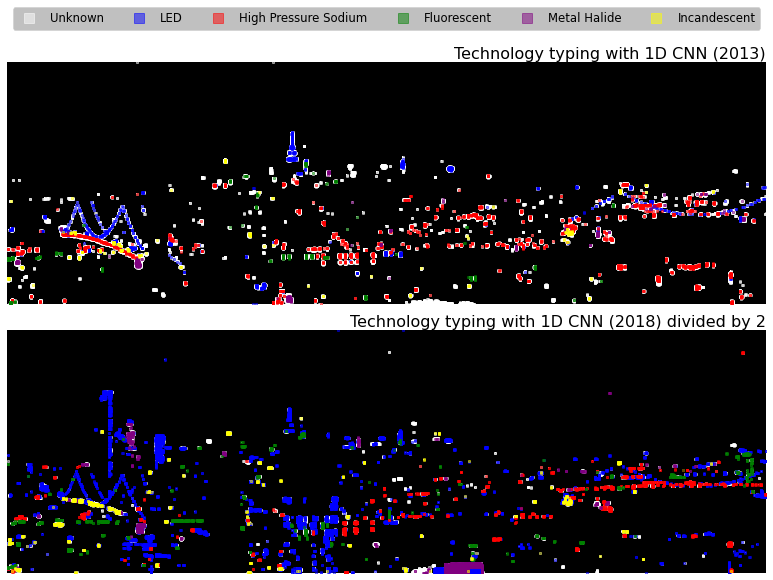

In [57]:
# -- imshow the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018) divided by 2", loc = "right", fontsize = 16)
fig.tight_layout()

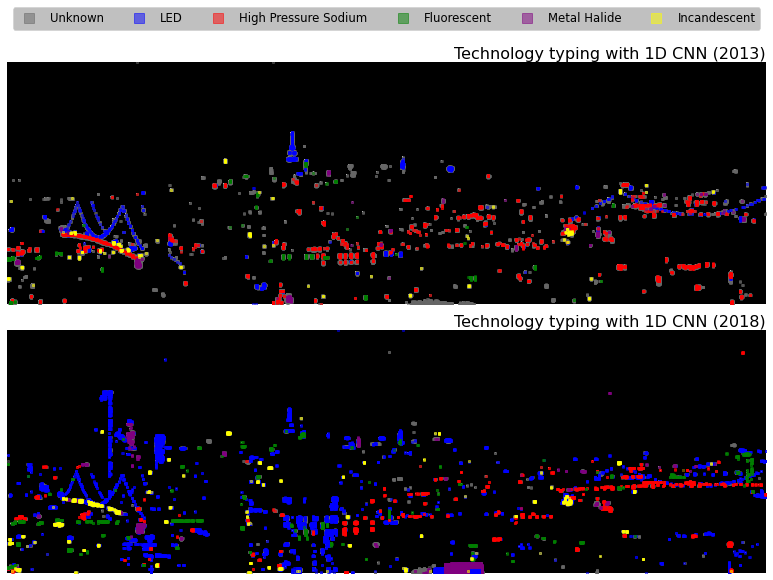

In [58]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

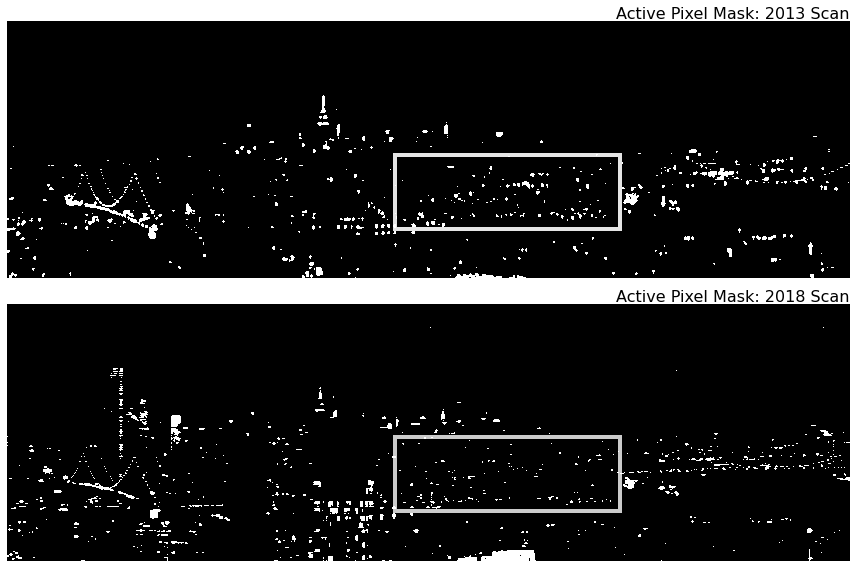

In [82]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

# ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
# ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

# ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
# ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

# ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Active Pixel Mask: 2013 Scan", loc = "right", fontsize = 16)

rect1 = patches.Rectangle((500, 360), 290, 200, linewidth=4, edgecolor='white', facecolor = 'none',zorder = 7, alpha = 0.9)
ax[0].add_patch(rect1)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
# ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
# ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

# ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
# ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect1 = patches.Rectangle((500, 360), 290, 200, linewidth=4, edgecolor='white', facecolor = 'none', zorder = 7, alpha = 0.8)

ax[1].add_patch(rect1)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Active Pixel Mask: 2018 Scan", loc = "right", fontsize = 16)
fig.tight_layout()

NameError: name 'unknown_hsi0' is not defined

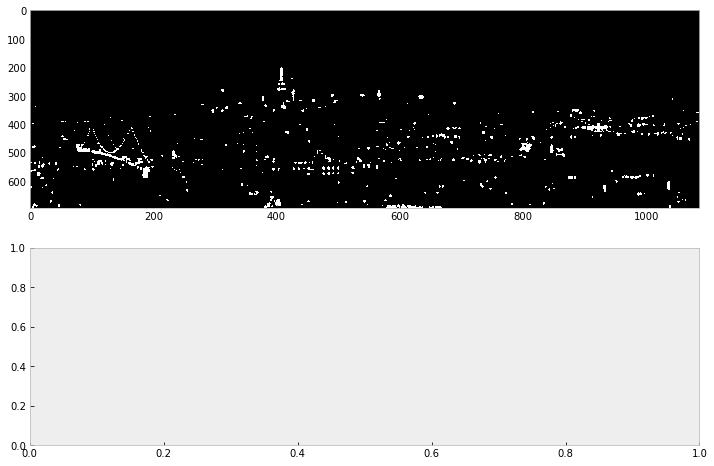

In [24]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

rect1 = patches.Rectangle((550, 450), 220, 110,  linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect1)

rect2 = patches.Rectangle((900, 550), 150, 65,  linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect2)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "cyan", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect3 = patches.Rectangle((550, 450), 220, 110,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect3)
rect4 = patches.Rectangle((900, 550), 150, 65,  linewidth=4, edgecolor='white', facecolor='none', zorder = 7, alpha = 0.8)
ax[1].add_patch(rect4)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

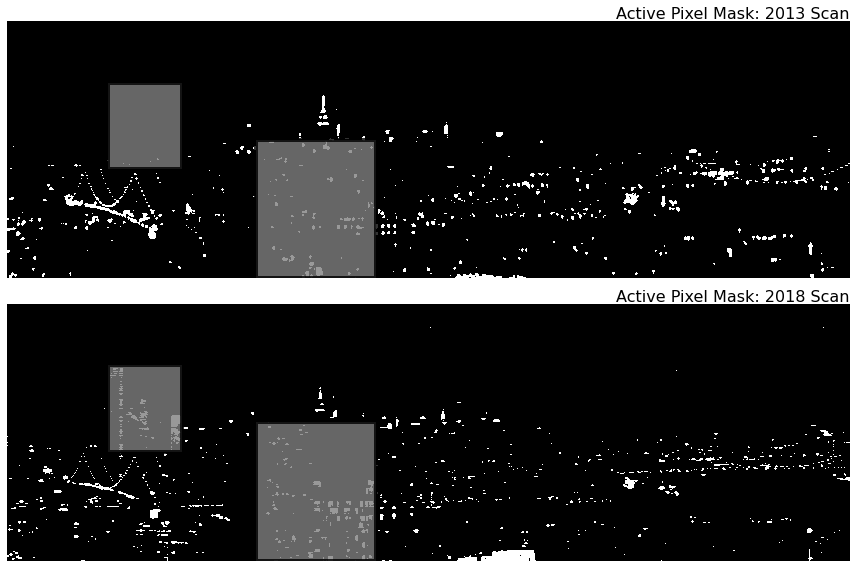

In [101]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

# ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)
# ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

# ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
# ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

# ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Active Pixel Mask: 2013 Scan", loc = "right", fontsize = 16)

rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='black', facecolor='grey', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='black', facecolor='grey', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
# ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)

# ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
# ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

# ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
# ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
# ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='black', facecolor='grey', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect2)
rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='black', facecolor='grey', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Active Pixel Mask: 2018 Scan", loc = "right", fontsize = 16)
fig.tight_layout()

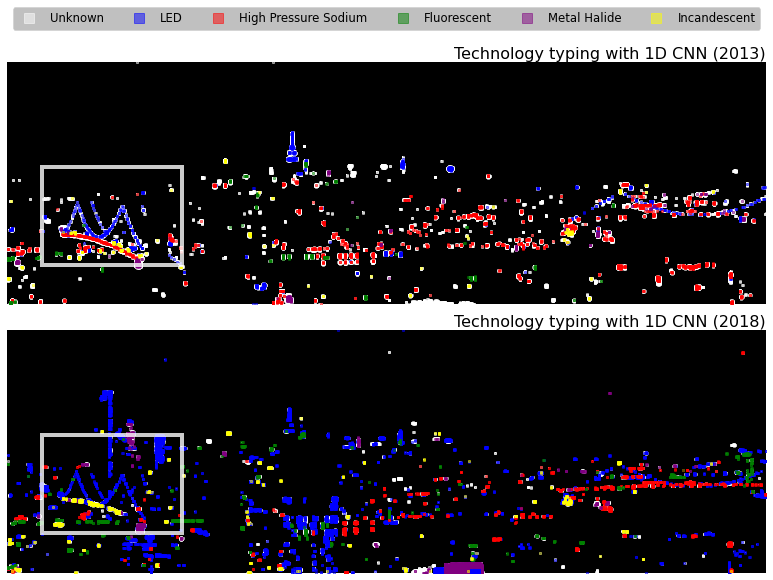

In [107]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_facecolor("#444444")
ax[0].set_title("Technology typing with 1D CNN (2013)", loc = "right", fontsize = 16)

# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[0].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[0].add_patch(rect)

rect = patches.Rectangle((50, 300), 200, 280, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[0].add_patch(rect)


# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "white", label = 'Unknown', alpha = 0.5)

ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Incandescent', alpha = 0.5)
# rect2 = patches.Rectangle((130, 165), 95, 235, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[1].add_patch(rect2)
# rect = patches.Rectangle((320, 320), 155, 374, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
# ax[1].add_patch(rect)
rect = patches.Rectangle((50, 300), 200, 280, linewidth=4, edgecolor='white', facecolor='none', zorder = 9, alpha = 0.8)
ax[1].add_patch(rect)
#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018)", loc = "right", fontsize = 16)
fig.tight_layout()

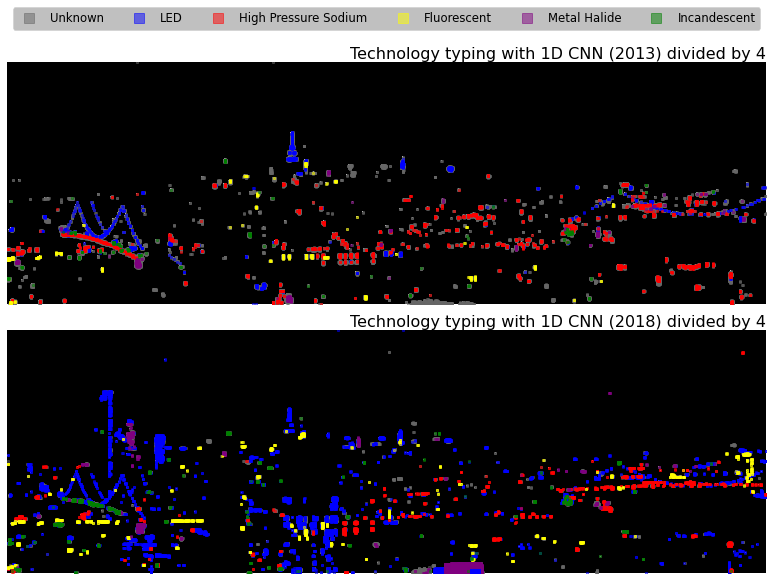

In [61]:
# -- imshoe the prediction
# -- this is for hsi0
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(((gf(1.0 * (imgL_hsi0 > 0.7), 1) > 0.25)), aspect="auto")

ax[0].plot(unknown_hsi0.loc_x, unknown_hsi0.loc_y, marker="s", linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[0].plot(LED_hsi0.loc_x, LED_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[0].plot(HPS_hsi0.loc_x, HPS_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High Pressure Sodium', alpha = 0.5)

ax[0].plot(CFL_hsi0.loc_x, CFL_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Fluorescent', alpha = 0.5)
ax[0].plot(MH_hsi0.loc_x, MH_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal Halide', alpha = 0.5)
ax[0].plot(INC_hsi0.loc_x, INC_hsi0.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Incandescent', alpha = 0.5)

ax[0].legend(markerscale=4, bbox_to_anchor=(1, 1.25), ncol=6, fontsize = 11.69, facecolor = "silver", framealpha = 1)
ax[0].axis('off')
ax[0].set_title("Technology typing with 1D CNN (2013) divided by 4", loc = "right", fontsize = 16)

# -- this is for hsi1
ax[1].imshow(((gf(1.0 * (imgL_hsi1 > 0.7), 1) > 0.25)), aspect="auto")
ax[1].plot(unknown_hsi1.loc_x, unknown_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "#666666", label = 'Unknown', alpha = 0.5)
ax[1].plot(LED_hsi1.loc_x, LED_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "blue", label = 'LED', alpha = 0.5)
ax[1].plot(HPS_hsi1.loc_x, HPS_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "red", label = 'High_pressure_sodium', alpha = 0.5)

ax[1].plot(CFL_hsi1.loc_x, CFL_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "yellow", label = 'Fluorescent', alpha = 0.5)
ax[1].plot(MH_hsi1.loc_x, MH_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "purple", label = 'Metal_Halide', alpha = 0.5)
ax[1].plot(INC_hsi1.loc_x, INC_hsi1.loc_y, marker='s', linestyle='', ms=2.5, c = "green", label = 'Incandescent', alpha = 0.5)

#ax.legend(markerscale=2, loc = "upper left")
ax[1].axis('off')

ax[1].set_title("Technology typing with 1D CNN (2018) divided by 4", loc = "right", fontsize = 16)
fig.tight_layout()

In [108]:
rgb_tech_hsi1 = np.zeros((695, 1087, 3))
rgb_tech_hsi0 = np.zeros((695, 1087, 3))


def get_rbg_loc(rgb_tech, src, r, g, b):
  for i in range(len(src)):
      rgb_tech[src.iloc[i].loc_y, src.iloc[i].loc_x] = (r, g, b)
  return rgb_tech

In [140]:
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, unknown_hsi0, 1, 1, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, HPS_hsi0, 1, 0, 0)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, LED_hsi0, 0, 0, 1)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, CFL_hsi0, 0, 128/255, 0)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, MH_hsi0, 128/255, 0, 128/255)
rgb_tech_hsi0 = get_rbg_loc(rgb_tech_hsi0, INC_hsi0, 1, 1, 0)


rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, unknown_hsi1, 1, 1, 1)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, HPS_hsi1, 1, 0, 0)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, LED_hsi1, 0, 0, 1)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, CFL_hsi1, 0, 128/255, 0)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, MH_hsi1, 128/255, 0, 128/255)
rgb_tech_hsi1 = get_rbg_loc(rgb_tech_hsi1, INC_hsi1, 1, 1, 0)

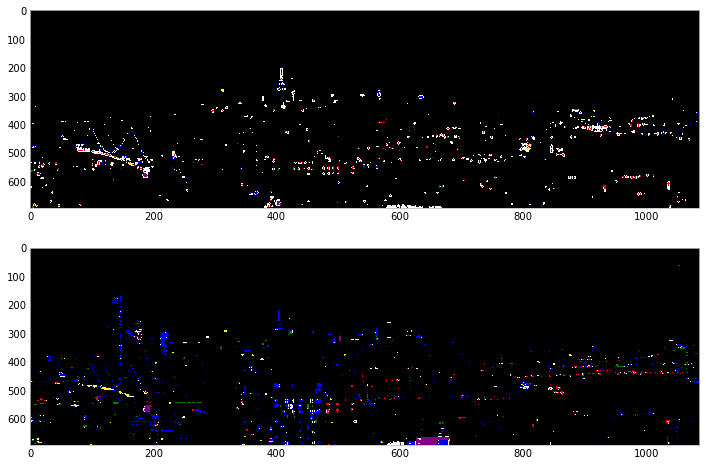

In [141]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))
ax[0].imshow(rgb_tech_hsi0, aspect="auto")
ax[1].imshow(rgb_tech_hsi1, aspect="auto")

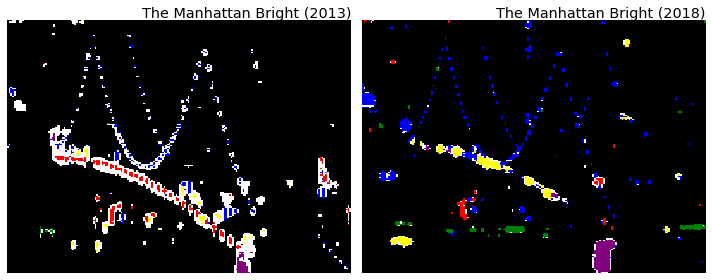

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ax[0].imshow(rgb_tech_hsi0[390:580, 50:250], aspect="auto")
ax[0].axis('off')
ax[0].set_title("The Manhattan Bright (2013)", loc = "right")

ax[1].axis('off')
ax[1].imshow(rgb_tech_hsi1[390:580, 50:250], aspect="auto")
ax[1].set_title("The Manhattan Bright (2018)", loc = "right")
fig.tight_layout()
# ax[0, 1].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
# ax[0, 1].axis('off')
# ax[0, 1].set_title("Residential Area", loc = "right")

# ax[1, 1].axis('off')
# ax[1, 1].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

# ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
# ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
# ax[0, 2].axis('off')
# ax[1, 2].axis('off')
# ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")

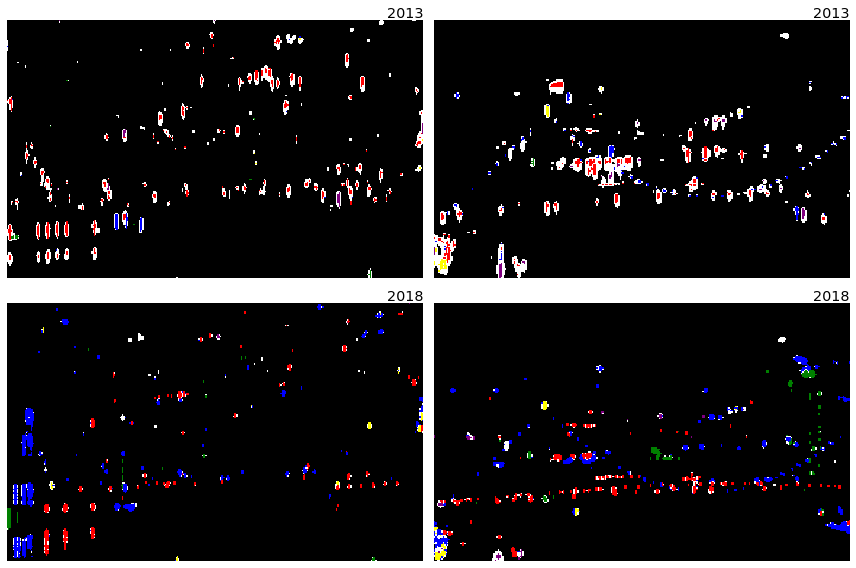

In [151]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (12, 8))

ax[0, 0].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
ax[0, 0].axis('off')
ax[0, 0].set_title("2013", loc = "right")

ax[1, 0].axis('off')
ax[1, 0].set_title("2018", loc = "right")
ax[1, 0].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

ax[0, 1].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
ax[0, 1].axis('off')
ax[0, 1].set_title("2013", loc = "right")

ax[1, 1].axis('off')
ax[1, 1].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")
ax[1, 1].set_title("2018", loc = "right")

fig.tight_layout()


# ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
# ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
# ax[0, 2].axis('off')
# ax[1, 2].axis('off')
# ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")

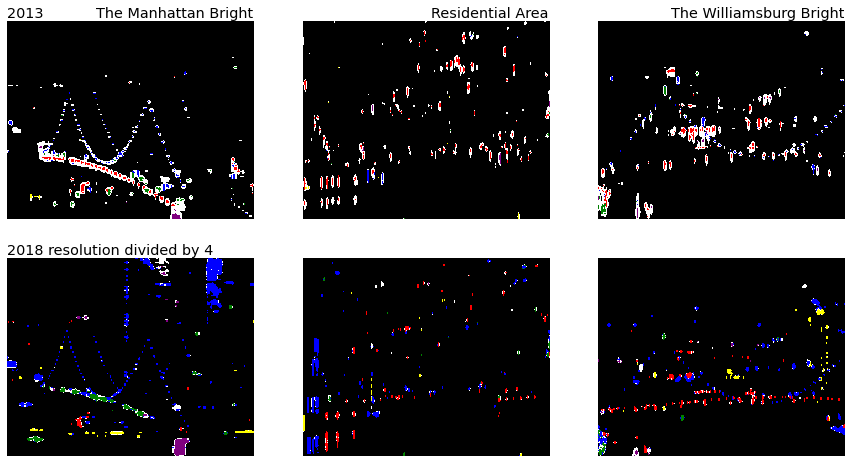

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))
ax[0, 0].imshow(rgb_tech_hsi0[300:580, 50:250], aspect="auto")
ax[0, 0].axis('off')
ax[0, 0].set_title("The Manhattan Bright", loc = "right")
ax[0, 0].set_title("2013", loc = "left")

ax[1, 0].axis('off')
ax[1, 0].set_title("2018 resolution divided by 4", loc = "left")
ax[1, 0].imshow(rgb_tech_hsi1[300:580, 50:250], aspect="auto")

ax[0, 1].imshow(rgb_tech_hsi0[400:590, 450:800], aspect="auto")
ax[0, 1].axis('off')
ax[0, 1].set_title("Residential Area", loc = "right")

ax[1, 1].axis('off')
ax[1, 1].imshow(rgb_tech_hsi1[400:590, 450:800], aspect="auto")

ax[0, 2].imshow(rgb_tech_hsi0[300:500, 800:], aspect="auto")
ax[0, 2].set_title("The Williamsburg Bright", loc = "right")
ax[0, 2].axis('off')
ax[1, 2].axis('off')
ax[1, 2].imshow(rgb_tech_hsi1[300:500, 800:], aspect="auto")